In [ ]:
#%%

import torch
import torch.nn as nn
import torch.optim as optim
import os 
import torchvision.models as models

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create Dataset

data_dur = "Stimuli/Set_E_face_images_1000_stim/faces_1000/faces_1000"

files = []

for dir in os.listdir(data_dur):
    if dir.startswith('.'):
        continue

    num = int(dir[2:])
 
    files.append(os.path.join(data_dur, dir))

        
print(f"Train files: {len(files)}")


class FaceDataset(torch.utils.data.Dataset):
    def __init__(self, file_list):
        self.file_list = file_list
        self.n_class = len(file_list)
        
        self.file_list_image_paths = [[] for _ in range(self.n_class)]
        for idx, file in enumerate(self.file_list):
            for image_file in os.listdir(file):
                if image_file.endswith('.jpg'):
                    self.file_list_image_paths[idx].append(os.path.join(file, image_file))
        
        for i in range(self.n_class):
            assert len(self.file_list_image_paths[i]) == 10, f"Expected 10 images per person, found {len(self.file_list_image_paths[i])} in {self.file_list[i]}"
            

    def __len__(self):
        return len(self.file_list) * 10

    def load_image(self, image_path):
        from PIL import Image
        import torchvision.transforms as transforms
        
        image = Image.open(image_path).convert('RGB')
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        return transform(image)

    def __getitem__(self, idx):
        file_idx = idx // 10
        image_idx = idx % 10
        image_path = self.file_list_image_paths[file_idx][image_idx]
        
        image = self.load_image(image_path)
        return image

# Create datasets
dataset = FaceDataset(files)

all_acc = []

# Print dataset sizes
print(f"dataset size: {len(dataset)}")
model = models.vgg16(pretrained=False)

# Remove the last layer
embedding_model = nn.Sequential(*list(model.children())[:-1])
# Move model to device
model = model.to(device)

num_correct = 0
total = 0

num_people = len(files)
for p1 in range(num_people):
    for p2 in range(p1 + 1, num_people):
        # Get random images from each person
        rand_idx = torch.randint(10, (2,))
        p1_idx = p1 * 10 + rand_idx[0].item()
        p2_idx = p2 * 10 + rand_idx[1].item()
        image1 = dataset[p1_idx].unsqueeze(0).to(device)
        image2 = dataset[p2_idx].unsqueeze(0).to(device)
    
        # Get another image of the first person
        p1_idx2 = p1 * 10 + (rand_idx[0] + 1) % 10
        target_image = dataset[p1_idx2].unsqueeze(0).to(device)
        
        # Get embeddings
        with torch.no_grad():
            embedding1 = embedding_model(image1)
            embedding2 = embedding_model(image2)
            target_embedding = embedding_model(target_image)
            
        # Calculate cosine similarity
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        similarity1 = cos(embedding1.view(1, -1), target_embedding.view(1, -1))
        similarity2 = cos(embedding2.view(1, -1), target_embedding.view(1, -1))
        
        if similarity1 > similarity2:
            num_correct += 1

        total += 1

Train files: 100
dataset size: 1000


c:\Users\seant\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\seant\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# %%

all_acc.append(num_correct / total * 100)
print(f"Accuracy: {num_correct / total * 100:.2f}%")

Accuracy: 61.52%


In [ ]:
# %%

model = models.vgg16(pretrained=True)

# Remove the last layer
embedding_model = nn.Sequential(*list(model.children())[:-1])
# Move model to device
model = model.to(device)

num_correct = 0
total = 0

num_people = len(files)
for p1 in range(num_people):
    for p2 in range(p1 + 1, num_people):
        # Get random images from each person
        rand_idx = torch.randint(10, (2,))
        p1_idx = p1 * 10 + rand_idx[0].item()
        p2_idx = p2 * 10 + rand_idx[1].item()
        image1 = dataset[p1_idx].unsqueeze(0).to(device)
        image2 = dataset[p2_idx].unsqueeze(0).to(device)
    
        # Get another image of the first person
        p1_idx2 = p1 * 10 + (rand_idx[0] + 1) % 10
        target_image = dataset[p1_idx2].unsqueeze(0).to(device)
        
        # Get embeddings
        with torch.no_grad():
            embedding1 = embedding_model(image1)
            embedding2 = embedding_model(image2)
            target_embedding = embedding_model(target_image)
            
        # Calculate cosine similarity
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        similarity1 = cos(embedding1.view(1, -1), target_embedding.view(1, -1))
        similarity2 = cos(embedding2.view(1, -1), target_embedding.view(1, -1))
        
        if similarity1 > similarity2:
            num_correct += 1

        total += 1

c:\Users\seant\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# %%

all_acc.append(num_correct / total * 100)
print(f"Accuracy: {num_correct / total * 100:.2f}%")

Accuracy: 78.24%


In [ ]:
# %%

# 1) Load your raw checkpoint
raw = torch.load("vgg_face_dag.pth", map_location="cpu")

# 2) Build a mapping from old→new prefixes
conv_map = {
    "conv1_1": "features.0",
    "conv1_2": "features.2",
    "conv2_1": "features.5",
    "conv2_2": "features.7",
    "conv3_1": "features.10",
    "conv3_2": "features.12",
    "conv3_3": "features.14",
    "conv4_1": "features.17",
    "conv4_2": "features.19",
    "conv4_3": "features.21",
    "conv5_1": "features.24",
    "conv5_2": "features.26",
    "conv5_3": "features.28",
}
fc_map = {
    "fc6": "classifier.0",
    "fc7": "classifier.3",
    "fc8": "classifier.6",
}

# 3) Remap all keys
new_state = {}
for k, v in raw.items():
    # split out the suffix (.weight or .bias)
    stem, suffix = k.rsplit(".", 1)
    if stem in conv_map:
        new_k = f"{conv_map[stem]}.{suffix}"
    elif stem in fc_map:
        new_k = f"{fc_map[stem]}.{suffix}"
    else:
        # skip anything else (e.g. dropout layers, if present)
        continue
    new_state[new_k] = v

# 4) Load into a fresh VGG-16
model = models.vgg16(pretrained=False)
model.classifier[6] = nn.Linear(4096, 2622)
missing, unexpected = model.load_state_dict(new_state, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

# Remove the last layer
embedding_model = nn.Sequential(*list(model.children())[:-1])
# Move model to device
embedding_model = embedding_model.to(device)
num_correct = 0
total = 0

for p1 in range(num_people):
    for p2 in range(p1 + 1, num_people):
        # Get random images from each person
        rand_idx = torch.randint(10, (2,))
        p1_idx = p1 * 10 + rand_idx[0].item()
        p2_idx = p2 * 10 + rand_idx[1].item()
        image1 = dataset[p1_idx].unsqueeze(0).to(device)
        image2 = dataset[p2_idx].unsqueeze(0).to(device)
    
        # Get another image of the first person
        p1_idx2 = p1 * 10 + (rand_idx[0] + 1) % 10
        target_image = dataset[p1_idx2].unsqueeze(0).to(device)
        
        # Get embeddings
        with torch.no_grad():
            embedding1 = embedding_model(image1)
            embedding2 = embedding_model(image2)
            target_embedding = embedding_model(target_image)
            
        # Calculate cosine similarity
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        similarity1 = cos(embedding1.view(1, -1), target_embedding.view(1, -1))
        similarity2 = cos(embedding2.view(1, -1), target_embedding.view(1, -1))
        
        if similarity1 > similarity2:
            num_correct += 1

        total += 1
        
# Print final accuracy
all_acc.append(num_correct / total * 100)
print(f"VGG Face Accuracy: {num_correct / total * 100:.2f}%")

<ipython-input-5-f288da1e775e>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load("vgg_face_dag.pth", map_location="cpu")


Missing keys: []
Unexpected keys: []
VGG Face Accuracy: 92.30%


In [ ]:
#%%

import torch
import torch.nn as nn
import torch.optim as optim
import os 
import torchvision.models as models

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create Dataset

data_dur = "Stimuli/Set_E_face_images_1000_stim/faces_1000/faces_1000"

files = []

for dir in os.listdir(data_dur):
    if dir.startswith('.'):
        continue

    num = int(dir[2:])
 
    files.append(os.path.join(data_dur, dir))

        
print(f"Train files: {len(files)}")


class FaceDataset(torch.utils.data.Dataset):
    def __init__(self, file_list):
        self.file_list = file_list
        self.n_class = len(file_list)
        
        self.file_list_image_paths = [[] for _ in range(self.n_class)]
        for idx, file in enumerate(self.file_list):
            for image_file in os.listdir(file):
                if image_file.endswith('.jpg'):
                    self.file_list_image_paths[idx].append(os.path.join(file, image_file))
        
        for i in range(self.n_class):
            assert len(self.file_list_image_paths[i]) == 10, f"Expected 10 images per person, found {len(self.file_list_image_paths[i])} in {self.file_list[i]}"
            

    def __len__(self):
        return len(self.file_list) * 10

    def load_image(self, image_path):
        from PIL import Image
        import torchvision.transforms as transforms
        
        image = Image.open(image_path).convert('RGB')
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.RandomVerticalFlip(p=1.0),  # Always flip the image vertically
        ])
        return transform(image)

    def __getitem__(self, idx):
        file_idx = idx // 10
        image_idx = idx % 10
        image_path = self.file_list_image_paths[file_idx][image_idx]
        
        image = self.load_image(image_path)
        return image

# Create datasets
dataset = FaceDataset(files)


# Print dataset sizes
print(f"dataset size: {len(dataset)}")
model = models.vgg16(pretrained=False)

# Remove the last layer
embedding_model = nn.Sequential(*list(model.children())[:-1])
# Move model to device
model = model.to(device)

num_correct = 0
total = 0

num_people = len(files)
for p1 in range(num_people):
    for p2 in range(p1 + 1, num_people):
        # Get random images from each person
        rand_idx = torch.randint(10, (2,))
        p1_idx = p1 * 10 + rand_idx[0].item()
        p2_idx = p2 * 10 + rand_idx[1].item()
        image1 = dataset[p1_idx].unsqueeze(0).to(device)
        image2 = dataset[p2_idx].unsqueeze(0).to(device)
    
        # Get another image of the first person
        p1_idx2 = p1 * 10 + (rand_idx[0] + 1) % 10
        target_image = dataset[p1_idx2].unsqueeze(0).to(device)
        
        # Get embeddings
        with torch.no_grad():
            embedding1 = embedding_model(image1)
            embedding2 = embedding_model(image2)
            target_embedding = embedding_model(target_image)
            
        # Calculate cosine similarity
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        similarity1 = cos(embedding1.view(1, -1), target_embedding.view(1, -1))
        similarity2 = cos(embedding2.view(1, -1), target_embedding.view(1, -1))
        
        if similarity1 > similarity2:
            num_correct += 1

        total += 1

Train files: 100
dataset size: 1000


In [ ]:
# %%

all_acc.append(num_correct / total * 100)
print(f"Accuracy: {num_correct / total * 100:.2f}%")

Accuracy: 61.37%


In [ ]:
# %%

model = models.vgg16(pretrained=True)

# Remove the last layer
embedding_model = nn.Sequential(*list(model.children())[:-1])
# Move model to device
model = model.to(device)

num_correct = 0
total = 0

num_people = len(files)
for p1 in range(num_people):
    for p2 in range(p1 + 1, num_people):
        # Get random images from each person
        rand_idx = torch.randint(10, (2,))
        p1_idx = p1 * 10 + rand_idx[0].item()
        p2_idx = p2 * 10 + rand_idx[1].item()
        image1 = dataset[p1_idx].unsqueeze(0).to(device)
        image2 = dataset[p2_idx].unsqueeze(0).to(device)
    
        # Get another image of the first person
        p1_idx2 = p1 * 10 + (rand_idx[0] + 1) % 10
        target_image = dataset[p1_idx2].unsqueeze(0).to(device)
        
        # Get embeddings
        with torch.no_grad():
            embedding1 = embedding_model(image1)
            embedding2 = embedding_model(image2)
            target_embedding = embedding_model(target_image)
            
        # Calculate cosine similarity
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        similarity1 = cos(embedding1.view(1, -1), target_embedding.view(1, -1))
        similarity2 = cos(embedding2.view(1, -1), target_embedding.view(1, -1))
        
        if similarity1 > similarity2:
            num_correct += 1

        total += 1

In [ ]:
# %%

all_acc.append(num_correct / total * 100)
print(f"Accuracy: {num_correct / total * 100:.2f}%")

Accuracy: 79.94%


In [ ]:
# %%

# 1) Load your raw checkpoint
raw = torch.load("vgg_face_dag.pth", map_location="cpu")

# 2) Build a mapping from old→new prefixes
conv_map = {
    "conv1_1": "features.0",
    "conv1_2": "features.2",
    "conv2_1": "features.5",
    "conv2_2": "features.7",
    "conv3_1": "features.10",
    "conv3_2": "features.12",
    "conv3_3": "features.14",
    "conv4_1": "features.17",
    "conv4_2": "features.19",
    "conv4_3": "features.21",
    "conv5_1": "features.24",
    "conv5_2": "features.26",
    "conv5_3": "features.28",
}
fc_map = {
    "fc6": "classifier.0",
    "fc7": "classifier.3",
    "fc8": "classifier.6",
}

# 3) Remap all keys
new_state = {}
for k, v in raw.items():
    # split out the suffix (.weight or .bias)
    stem, suffix = k.rsplit(".", 1)
    if stem in conv_map:
        new_k = f"{conv_map[stem]}.{suffix}"
    elif stem in fc_map:
        new_k = f"{fc_map[stem]}.{suffix}"
    else:
        # skip anything else (e.g. dropout layers, if present)
        continue
    new_state[new_k] = v

# 4) Load into a fresh VGG-16
model = models.vgg16(pretrained=False)
model.classifier[6] = nn.Linear(4096, 2622)
missing, unexpected = model.load_state_dict(new_state, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

# Remove the last layer
embedding_model = nn.Sequential(*list(model.children())[:-1])
# Move model to device
embedding_model = embedding_model.to(device)
num_correct = 0
total = 0

for p1 in range(num_people):
    for p2 in range(p1 + 1, num_people):
        # Get random images from each person
        rand_idx = torch.randint(10, (2,))
        p1_idx = p1 * 10 + rand_idx[0].item()
        p2_idx = p2 * 10 + rand_idx[1].item()
        image1 = dataset[p1_idx].unsqueeze(0).to(device)
        image2 = dataset[p2_idx].unsqueeze(0).to(device)
    
        # Get another image of the first person
        p1_idx2 = p1 * 10 + (rand_idx[0] + 1) % 10
        target_image = dataset[p1_idx2].unsqueeze(0).to(device)
        
        # Get embeddings
        with torch.no_grad():
            embedding1 = embedding_model(image1)
            embedding2 = embedding_model(image2)
            target_embedding = embedding_model(target_image)
            
        # Calculate cosine similarity
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        similarity1 = cos(embedding1.view(1, -1), target_embedding.view(1, -1))
        similarity2 = cos(embedding2.view(1, -1), target_embedding.view(1, -1))
        
        if similarity1 > similarity2:
            num_correct += 1

        total += 1
                  
# Print final accuracy
all_acc.append(num_correct / total * 100)
print(f"VGG Face Accuracy: {num_correct / total * 100:.2f}%")
# Save the model

<ipython-input-10-525f2e06c46c>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load("vgg_face_dag.pth", map_location="cpu")


Missing keys: []
Unexpected keys: []
VGG Face Accuracy: 77.64%


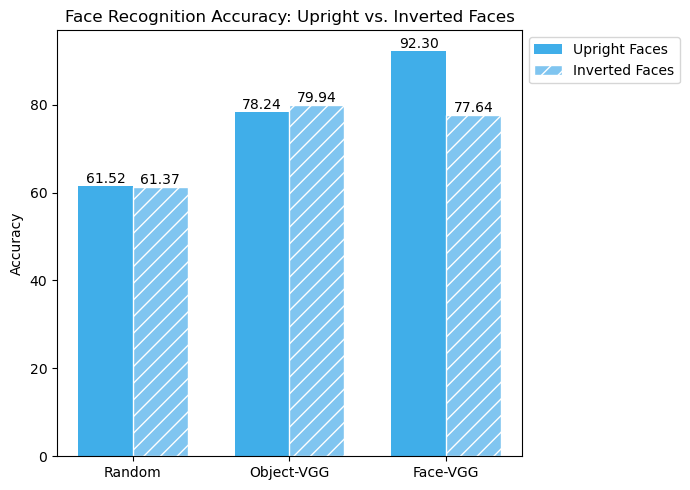

In [ ]:
# %%

import matplotlib.pyplot as plt
import numpy as np

models = ['Random', 'Object-VGG', 'Face-VGG']

upright_acc = [all_acc[0], all_acc[1], all_acc[2]]
inverted_acc = [all_acc[3], all_acc[4], all_acc[5]]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(7, 5))

bars_upright = ax.bar(x - width/2, upright_acc, width, label='Upright Faces', color="#40aee9")
bars_inverted = ax.bar(x + width/2, inverted_acc, width, label='Inverted Faces', hatch='//',edgecolor='white', color="#80c5f0")

# Axis and labels
ax.set_ylabel('Accuracy')
ax.set_title('Face Recognition Accuracy: Upright vs. Inverted Faces')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# Optional: Add value labels
for bar_group in [bars_upright, bars_inverted]:
    for bar in bar_group:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()